# Adding External Variables to Our Model

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Gross Domestic Product (GDP) Dataset

In [4]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


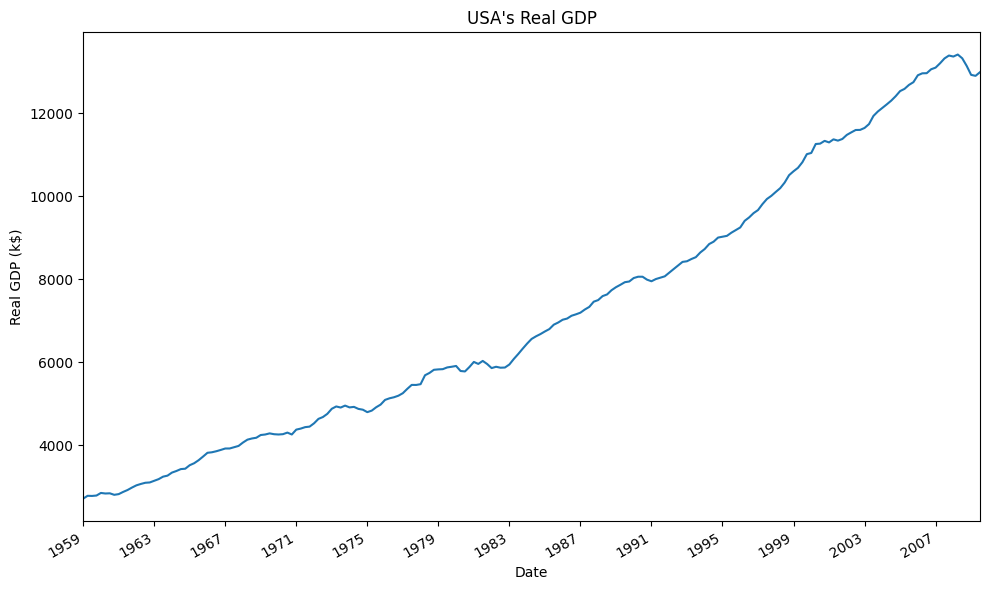

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')
ax.set_title("USA's Real GDP")

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
ax.set_xlim(0, 202) 

fig.autofmt_xdate()
plt.tight_layout()

Real gross domestic product (GDP) of the United States from 1959 to 2009.
The data was collected quarterly and is expressed in thousands of US dollars. Notice the
clear positive trend over the years with no cyclical pattern, suggesting that seasonality
is not present in the series.

### Description of all variables in the US macroeconomics dataset

| **Variable** | **Description** |
|--------------|-----------------|
| `realgdp`   | Real gross domestic product (the target variable or endogenous variable) |
| `realcons`  | Real personal consumption expenditure |
| `realinv`   | Real gross private domestic investment |
| `realgovt`  | Real federal consumption expenditure and investment |
| `realdpi`   | Real private disposable income |
| `cpi`       | Consumer price index for the end of the quarter |


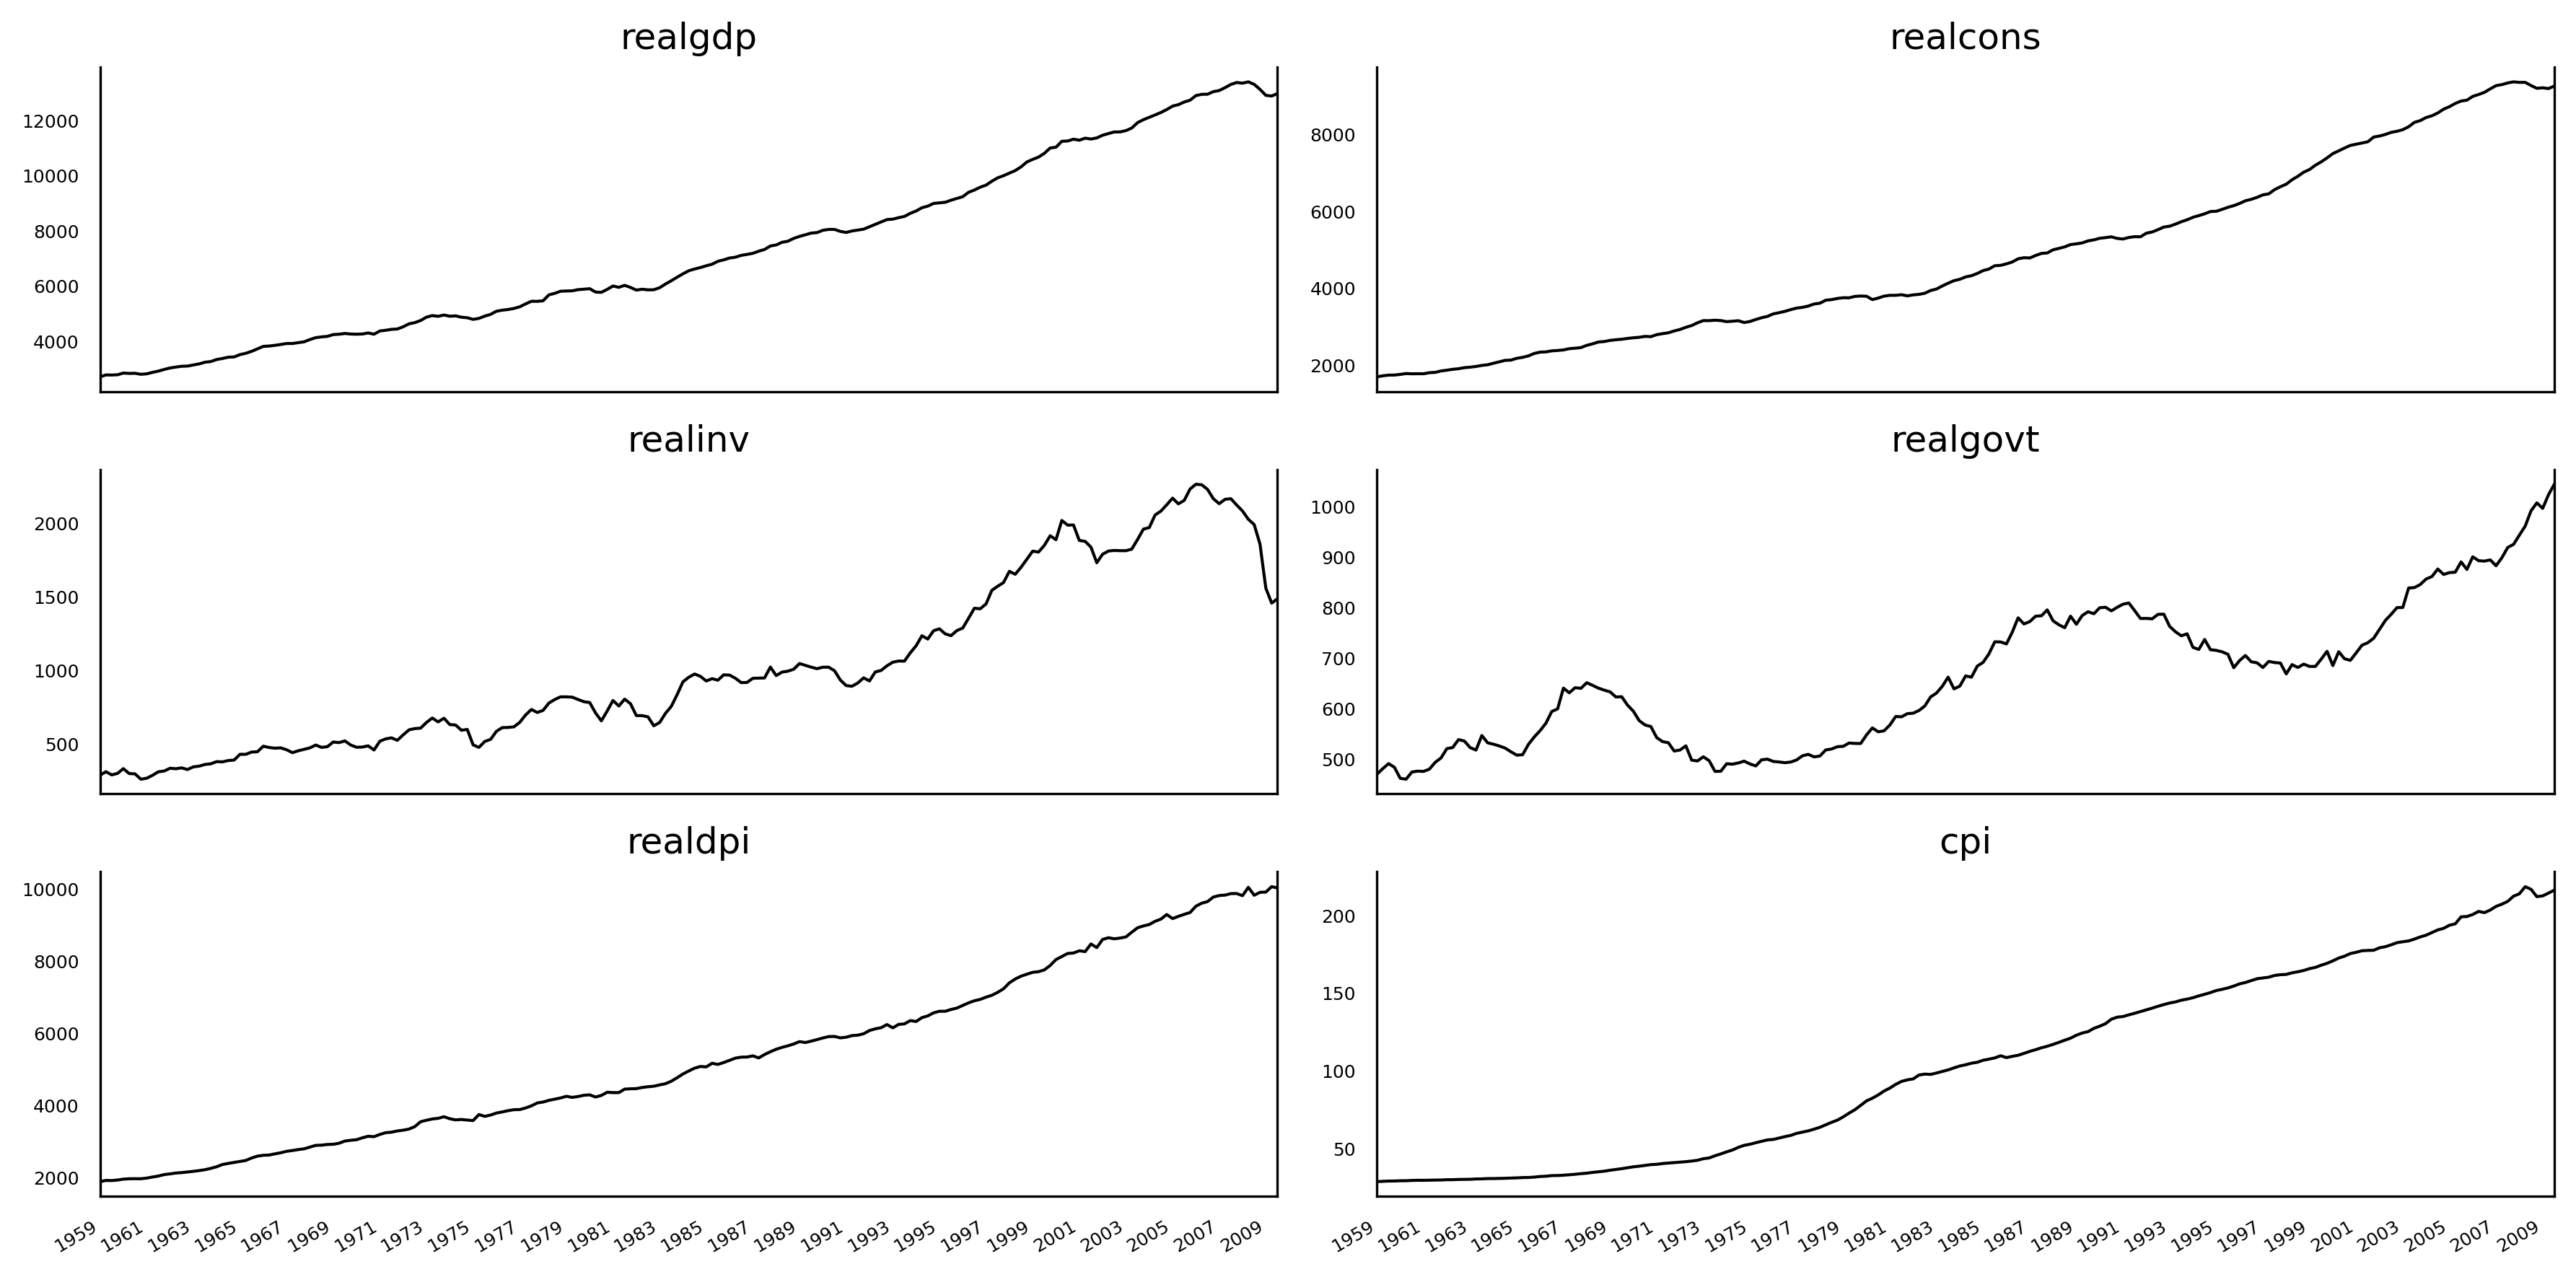

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(12,6))

for i, ax in enumerate(axes.flatten()[:6]):               # Iterate for six variables
    data = macro_econ_data[macro_econ_data.columns[i+2]]  # Skip the year and quarter columns
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])            # Display the variable's name at the top of the plot
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.set_xlim(0, 202)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

*Evolution of the real GDP and five exogenous variables from 1959 to 2009. You’ll notice that
realgdp, realcons, realdpi, and cpi all have a similar shape, which means that realcons, realdpi,
and cpi are potentially good predictors, although a graphical analysis is not sufficient to confirm that idea. On
the other hand, realgovt has peaks and troughs that do not appear in realgdp, so we can hypothesize that
realgovt is a weaker predictor.*

There are two ways to work with exogenous variables for time series forecasting. First,
we could train multiple models with various combinations of exogenous variables, and
see which model generates the best forecasts. Alternatively, we can simply include all
exogenous variables and stick to model selection using the AIC, as we know this yields
a good-fitting model that does not overfit.

In the analysis, we can see the p-value associated with each coefficient of each predictor of the SARIMAX model. Often the p-value is misused as a way to perform feature selection. Many incorrectly interpret the p-value as a way to determine if a
predictor is correlated with the target.
    
In fact, the p-value tests whether the coefficient is significantly different from 0 or not.
If the p-value is less than 0.05, then we reject the null hypothesis and conclude that
the coefficient is significantly different from 0. It does not determine whether a predictor is useful for forecasting.
                                                                                                      
Therefore, **we should not remove predictors based on their p-values**. Selecting the
model by minimizing the AIC takes care of that step.

## Forecasting the real GDP using the SARIMAX model

In [13]:
# Define the target variable. In this case, it is the real GDP
target = macro_econ_data['realgdp']

# Define the exogenous variables. Here we limit it to five variables for simplicity
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [14]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(target)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 1.750462796764709
p-value: 0.9982455372335032

p-value > alpha; H0: Not Stationary


Therefore, we must apply a transformation and test for stationarity again. Here we will difference the series once:

In [16]:
# Compute the difference of the target series to make it stationary (differencing)
target_diff = target.diff() #<==== Difference the series

ad_fuller_result1 = adfuller(target_diff[1:]) # ADF test starting from the second element

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08

p-value < alpha; Ha: Stationary


    Therefore, we know that d = 1. Since we did not need to take a seasonal difference to make the series stationary, D = 0.

In [18]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,  #<==== Exogenous variables
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [19]:
p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 4, 1)
Q = range(0, 4, 1)

d = 1  #<==== Number of derivatives until Stationy
D = 0  #<==== No seasonality
s = 4  #<==== 4 inputs by year

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [20]:
target_train = target[:200] # The first 200 points of the target is assigned to the target_train set
exog_train = exog[:200]     # The first 200 points of the exog is assigned to the exog_train set

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824292
1,"(3, 3, 1, 0)",1744.963197
2,"(3, 3, 0, 1)",1744.999291
3,"(2, 2, 0, 0)",1745.496477
4,"(3, 3, 2, 2)",1746.301139
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


Best Model:

    non-seasonal order: (p=3, d=1, q=3)
        seasonal order: (P=0, D=0, Q=0, s=4)

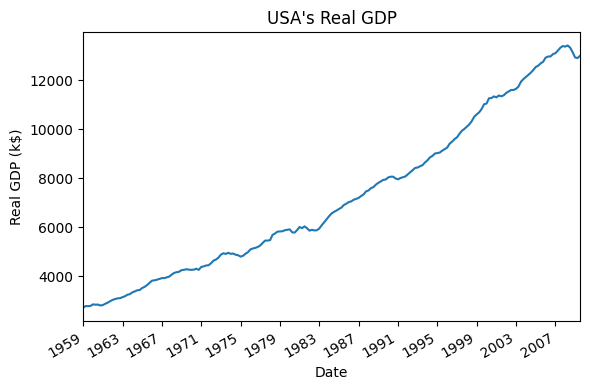

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')
ax.set_title("USA's Real GDP")

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
ax.set_xlim(0, 202) 

fig.autofmt_xdate()
plt.tight_layout()

*Notice the clear positive trend over the years with no cyclical pattern, suggesting that seasonality is not present in the series.*

In [24]:
# Define the SARIMA model with non-seasonal order (p=3, d=1, q=3) and seasonal order (P=0, D=0, Q=0, s=4)
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)

# Fit the model
best_model_fit = best_model.fit(disp=False)  

# Display Summary
best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Tue, 18 Feb 2025   AIC                           1742.824
Time:                        14:11:45   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.509      0.000       0.882       1.059
realinv        1.0132      0.033     30.696      0.000       0.949       1.078
realgovt       0.7282      0.127      5.728      0.000       0.479       0.977
realdpi        0.0102      0.025      0.407      0.684      -0.039       0.059
cpi            5.8715      1.299      4.520      0.000       3.325       8.418
ar.L1          1.0637      0.402      2.645      0.008       0.276       1.852
ar.L2          0.4953      0.708      0.699      0.484      -0.893       1.883
ar.L3         -0.6763      0.340     -1.989      0.047      -1.343      -0.010
ma.L1         -1.1030      0.434     -2.541      0.011      -1.954      -0.252
ma.L2         -0.3280      0.775     -0.423      0.672      -1.847       1.191
ma.L3          0.6515      0.407      1.599      0.110      -0.147       1.450
sigma2       331.2661     30.730     10.780      0.000     271.036     391.497
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.34
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.57   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We notice that all exogenous variables have a p-value smaller than
0.05, except for `realdpi`, which has a p-value of 0.712. This means that the coefficient
of realdpi is not significantly different from 0. We’ll also notice that its coefficient is
0.0091. However, the coefficient is kept in the model, as the p-value does not determine the relevance of this predictor in forecasting our target.

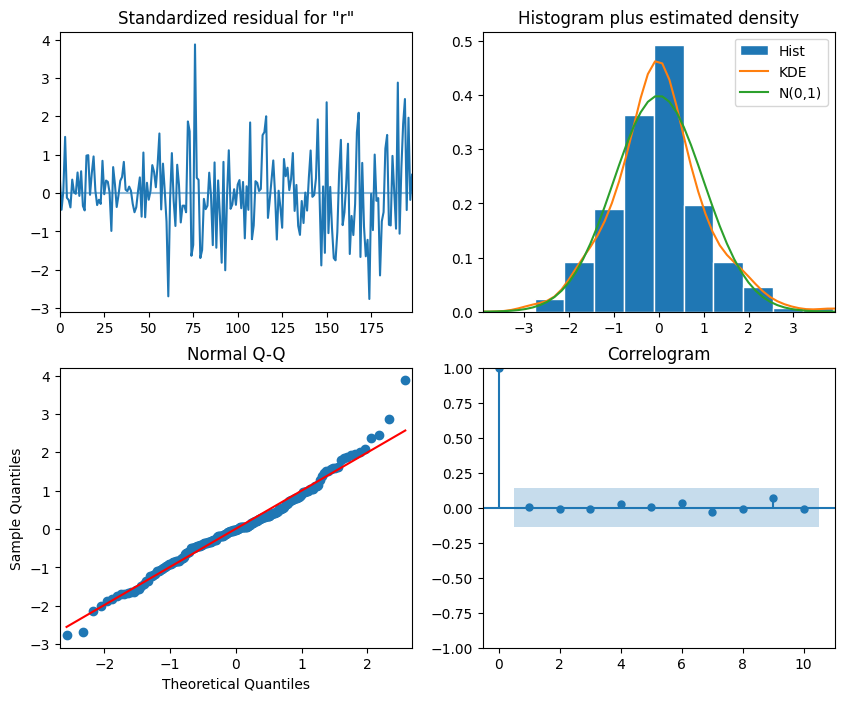

In [26]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8));

Residual analysis of the selected model. You can see that **the residuals** have no trend and
a fairly constant variance over time, just like white noise. In the **top-right plot**, the distribution of
residuals is very close to a normal distribution. This is further supported by the **Q-Q plot** at the bottom
left, which shows a fairly straight line that lies on y = x. Finally, the **correlogram** shows no significant
coefficients after lag 0, just like white noise. Therefore, from a graphical analysis, the residuals of this
model resemble white noise.

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals (errors) from the fitted model
residuals = best_model_fit.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.092326,0.761240
2,0.199124,0.905234
3,0.201197,0.977396
4,1.256693,0.868679
5,1.257490,0.939245
6,1.284589,0.972501
7,1.476455,0.983114
8,1.486428,0.992931
9,1.858581,0.993512
10,1.865243,0.997272


Instead, to test our model, we predict the next timestep multiple times and average
the errors of each prediction. This is done using the rolling_forecast function. As a baseline model, we will use
the last known value method.

In [30]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False) #<==== Best Model!
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

    [We fit the model on the data from 1959 to the end of 2007] 
    196
    
    [The test set contains the values starting in 2008 to the third quarter of 2009. There is a total of seven values to predict] 
    203 - 196 = 7

In [32]:
target_train = target[:196]   # The first 196 points are assigned to the train set
target_test = target[196:]    # The points after 196 are assigned to the test set

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.067262
197,13415.266,13366.865,13373.512082
198,13324.600,13415.266,13378.811688
199,13141.920,13324.600,13327.773467
200,12925.410,13141.920,13133.238726
201,12901.504,12925.410,12886.852572
202,12990.341,12901.504,12873.795026


In [33]:
# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
from sklearn.metrics import mean_absolute_error

# Calculate MAPE for each forecast
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

# Display MAPE results
print(f'   MAE for Naive Baseline: {mape_last:.2f}')
print(f' MAE for SARIMAX Forecast: {mape_SARIMAX:.2f}')

   MAE for Naive Baseline: 0.74
 MAE for SARIMAX Forecast: 0.70


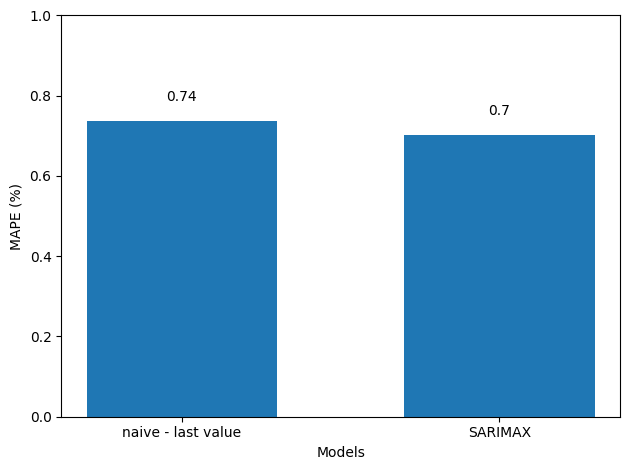

In [35]:
fig, ax = plt.subplots()

x = ['naive - last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

The mean absolute percentage error (MAPE) of the forecasts of each
method. You can see that the SARIMAX model only has a slightly smaller MAPE than
the baseline. This highlights the importance of using a baseline, as a MAPE of 0.70%
is extremely good, but a naive forecast achieves a MAPE of 0.74%, meaning that the
SARIMAX model only has a small advantage.

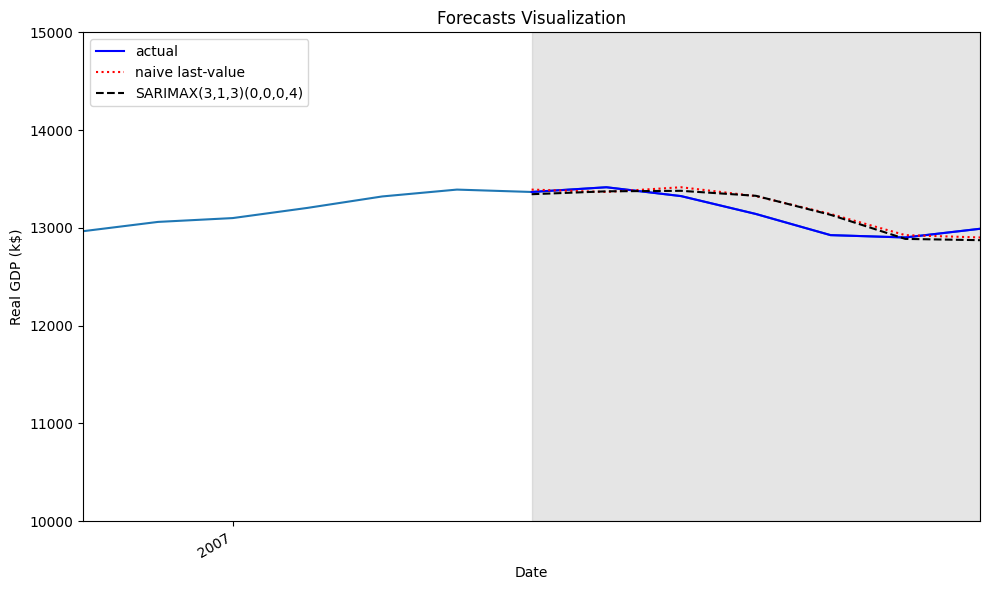

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(macro_econ_data['realgdp'])
ax.plot(pred_df['actual'], 'b-', label='actual')
ax.plot(pred_df['pred_last_value'], 'r:', label='naive last-value')
ax.plot(pred_df['pred_SARIMAX'], 'k--', label='SARIMAX(3,1,3)(0,0,0,4)')
ax.set_title('Forecasts Visualization')

ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')
ax.axvspan(196, 202, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
ax.set_xlim(190, 202)
ax.set_ylim(10000, 15000)

fig.autofmt_xdate()
plt.tight_layout()

the SARIMAX model is the winning model by only 0.04%.
You’ll appreciate the importance of a baseline here, as both methods achieve an extremely low MAPE, showing that the SARIMAX model is only slightly better than
simply predicting the last value. This is where the business context comes into play. In
our case, since we are predicting the real GDP of the United States, a difference of
0.04% represents thousands of dollars. This difference might be relevant in this particular context, justifying the use of the SARIMAX model, even though it is only
slightly better than the baseline.

#### Summary

    The SARIMAX model allows you to include external variables, also termed exogenous variables, to forecast your target.
    
    Transformations are applied only on the target variable, not on the exogenous variables.
    
    If you wish to forecast multiple timesteps into the future, the exogenous variables must also be forecast. This can magnify the errors on the final forecast. To avoid that, you must predict only the next timestep.